# Capstone Project Notebook
This Notebook is the work support for the _Applied Data Science Capstone_ assessment, part of the **IBM Data Science** certification.<br>
It will be mainly used for the Capstone Project.

In [421]:
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Part I - Find the best Neighborhood
Get each Paris neighborhood coordinates

In [422]:
path = r'C:\Users\Thomas\Desktop\Projects\Coursera_Capstone\quartier_paris.csv'
df = pd.read_csv(path, delimiter = ';')

df.drop(['N_SQ_QU', 'C_QU', 'C_QUINSEE', 'C_AR', 'N_SQ_AR', 'PERIMETRE', 'SURFACE', 'Geometry'], 1, inplace = True)
df.columns = ['Neighborhood', 'Coordinates']

new = df['Coordinates'].str.split(',', expand = True)
df['Latitude'] = new[0]
df['Longitude'] = new[1]
df.drop(['Coordinates'], 1, inplace = True)

df[['Latitude','Longitude']] = df[['Latitude','Longitude']].apply(pd.to_numeric)

df

,Neighborhood,Latitude,Longitude
0,Notre-Dame-des-Champs,48.846428,2.327357
1,Petit-Montrouge,48.826653,2.326437
2,Pont-de-Flandre,48.895556,2.384777
3,Muette,48.863275,2.259936
4,Chaillot,48.868434,2.291679
...,...,...,...
75,Ternes,48.881178,2.289964
76,Val-de-Grâce,48.841684,2.343861
77,Necker,48.842711,2.310777
78,Père-Lachaise,48.863719,2.395273


Get the venues for each neighborhood using Foursquare API

In [423]:
import requests
from pandas import json_normalize

CLIENT_ID = 'UJJ2TE4RBPZAO1SF2ZQLHA0CL13JVICYNALW5DWNIQOYVDVD'
CLIENT_SECRET = 'AIR0X0S1CGPONGNG5XG0OP3GKFEEEJO3NOJ52CKQ0N5BDICC'
VERSION = '20200606'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [424]:
paris_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])
paris_venues

,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Notre-Dame-des-Champs,48.846428,2.327357,Legend Hotel,48.845316,2.325507,Hotel
1,Notre-Dame-des-Champs,48.846428,2.327357,Gilles Verot,48.847118,2.326819,Deli / Bodega
2,Notre-Dame-des-Champs,48.846428,2.327357,Sadaharu Aoki | 青木定治,48.848013,2.330366,Dessert Shop
3,Notre-Dame-des-Champs,48.846428,2.327357,Marché de Raspail,48.848807,2.327526,Market
4,Notre-Dame-des-Champs,48.846428,2.327357,Bagels & Brownies,48.846537,2.327329,Bagel Shop
...,...,...,...,...,...,...,...
5195,La Chapelle,48.894012,2.364387,New-Thaï San,48.891324,2.361265,Asian Restaurant
5196,La Chapelle,48.894012,2.364387,Carrefour City,48.889998,2.361442,Supermarket
5197,La Chapelle,48.894012,2.364387,Restaurant Tin Tin,48.891163,2.360850,Chinese Restaurant
5198,La Chapelle,48.894012,2.364387,Le Five Paris,48.896396,2.362536,Soccer Field


Save the table in an Excel file as back-up

In [606]:
writer = pd.ExcelWriter(r'C:\Users\Thomas\Desktop\Projects\Coursera_Capstone\quartier_paris_venues.xlsx')
df.to_excel(writer, index = False)
writer.save()

Get the venues from Danemark location

In [426]:
Latitude = 55.676428
Longitude = 12.548886
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Latitude, 
    Longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [427]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [428]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.columns = ['Name', 'Category']

nearby_venues

,Name,Category
0,Sound Station,Music Store
1,Hart Bageri,Bakery
2,Juul's Vin og Spiritus,Wine Shop
3,Falernum,Wine Bar
4,Pizzicato,Pizza Place
5,Ganni,Women's Store
6,Meyers Deli,Deli / Bodega
7,Social Foodies,Ice Cream Shop
8,Ipsen & Co,Café
9,Vinstue 90,Bar


Save the table in an Excel file as back-up

In [429]:
writer = pd.ExcelWriter(r'C:\Users\Thomas\Desktop\Projects\Coursera_Capstone\denmark_venues.xlsx')
df.to_excel(writer, index = False)
writer.save()

Make the user input table for recommendation machine learning

In [430]:
user_profile = nearby_venues.drop(['Name'], 1)
user_profile = user_profile.groupby(['Category']).size().reset_index(name = 'Counts')
user_profile

,Category,Counts
0,Asian Restaurant,2
1,Bakery,4
2,Bar,1
3,Bookstore,2
4,Burger Joint,1
5,Café,3
6,Cheese Shop,1
7,Cocktail Bar,2
8,Coffee Shop,3
9,Deli / Bodega,2


Normalize the counts

In [431]:
user_profile['Score'] = (user_profile['Counts']-user_profile['Counts'].min())/(user_profile['Counts'].max()-user_profile['Counts'].min())
user_profile = user_profile.drop(['Counts'], 1)

user_profile

,Category,Score
0,Asian Restaurant,0.333333
1,Bakery,1.000000
2,Bar,0.000000
3,Bookstore,0.333333
4,Burger Joint,0.000000
5,Café,0.666667
6,Cheese Shop,0.000000
7,Cocktail Bar,0.333333
8,Coffee Shop,0.666667
9,Deli / Bodega,0.333333


Take the venues from Paris and keep the lines with the categories that exist in the user profile

In [447]:
user_category = user_profile['Category'].to_list()

match_venues = paris_venues.loc[paris_venues['Venue Category'].isin(user_category)]
match_venues

,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Notre-Dame-des-Champs,48.846428,2.327357,Legend Hotel,48.845316,2.325507,Hotel
1,Notre-Dame-des-Champs,48.846428,2.327357,Gilles Verot,48.847118,2.326819,Deli / Bodega
5,Notre-Dame-des-Champs,48.846428,2.327357,Mamie Gâteaux,48.848513,2.324560,French Restaurant
6,Notre-Dame-des-Champs,48.846428,2.327357,Hôtel Le Littré,48.845458,2.324139,Hotel
9,Notre-Dame-des-Champs,48.846428,2.327357,Le Café Alain Ducasse,48.849208,2.325628,Coffee Shop
...,...,...,...,...,...,...,...
5191,La Chapelle,48.894012,2.364387,La Vieille Pie,48.889883,2.363067,French Restaurant
5192,La Chapelle,48.894012,2.364387,New Locomotive,48.891288,2.361936,Vietnamese Restaurant
5193,La Chapelle,48.894012,2.364387,Hanouman,48.891233,2.362396,Thai Restaurant
5195,La Chapelle,48.894012,2.364387,New-Thaï San,48.891324,2.361265,Asian Restaurant


Match the venues from Paris with the user profile to obtain neighborhood venues scores

In [448]:
match_venues = match_venues.merge(user_profile, left_on = 'Venue Category', right_on = 'Category')

match_venues = match_venues[['Neighborhood', 'Score']]

match_venues

,Neighborhood,Score
0,Notre-Dame-des-Champs,0.333333
1,Notre-Dame-des-Champs,0.333333
2,Notre-Dame-des-Champs,0.333333
3,Notre-Dame-des-Champs,0.333333
4,Notre-Dame-des-Champs,0.333333
...,...,...
2933,Arts-et-Métiers,0.000000
2934,Saint-Merri,0.000000
2935,Saint-Merri,0.000000
2936,Quinze-Vingts,0.000000


Sum in each neighborhood to obtain neighborhood overall scores

In [449]:
match_venues = match_venues.groupby(['Neighborhood']).sum()
match_venues = match_venues.reset_index()
match_venues

,Neighborhood,Score
0,Amérique,3.333333
1,Archives,26.000000
2,Arsenal,20.000000
3,Arts-et-Métiers,26.666667
4,Auteuil,1.000000
...,...,...
75,Sorbonne,26.666667
76,Ternes,30.666667
77,Val-de-Grâce,12.333333
78,Villette,12.333333


In [451]:
match_venues_short = match_venues.loc[match_venues['Score'] > 25]
match_venues_short = match_venues_short.sort_values(['Score'], ascending = False).reset_index()
match_venues_short

,index,Neighborhood,Score
0,29,Gros-Caillou,52.000000
1,10,Chaillot,41.333333
2,5,Batignolles,39.000000
3,44,Notre-Dame-des-Champs,34.666667
4,21,Faubourg-Montmartre,34.000000
5,59,Rochechouart,33.666667
6,69,Saint-Thomas-d'Aquin,32.666667
7,70,Saint-Victor,31.666667
8,31,Hôpital-Saint-Louis,31.666667
9,64,Saint-Germain-des-Prés,31.000000


Plot with Seaborn the scores

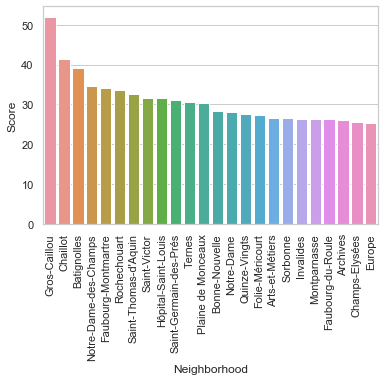

In [452]:
import seaborn as sns
plot_match = sns.barplot(x=match_venues_short['Neighborhood'], y=match_venues_short['Score'], data=match_venues_short)
for item in plot_match.get_xticklabels():
    item.set_rotation(90)

# Part II - Explore the Surroundings
Get the transportation stations coordinates in Paris

In [437]:
path = r'C:\Users\Thomas\Desktop\Projects\Coursera_Capstone\metro_location.csv'
df = pd.read_csv(path, delimiter = ';')
df

,ID,Name,Description,Coordinates
0,3677704,LA MOGOTTE,RUE DE LA MOGOTTE - 77468,"48.8515313627,2.63775356847"
1,3677668,LYCEE EMILY BRONTE,RUE GABRIEL - 77258,"48.839179854,2.63877127865"
2,3677692,LES QUATRE PAVES,ROND-POINT DES QUATRE PAVES - 77337,"48.8516342568,2.62146597068"
3,6869589,SUZANNE BUISSON,AVENUE HENRI VARAGNAT - 93010,"48.9135017218,2.48226363192"
4,3678794,MARGUILLIERS,RUE DES BUISSONS - 93073,"48.9943877703,2.52362352497"
...,...,...,...,...
25333,4614687,CIMETIERE DE VILLEMOMBLE,FACE 106 AVENUE DE ROSNY - 93077,"48.8829598929,2.4989667209"
25334,3909093,PIERRE CORBY,3 R PIERRE CORBY - 92023,"48.8000678345,2.26860247285"
25335,4614714,RENE CAMIER,AVENUE PAUL VAILLANT-COUTURIER - 93008,"48.9087095207,2.45108331156"
25336,3909105,CARREFOUR DES MOUILLEBOEUFS,FACE 84 AVENUE JEAN MOULIN - 92032,"48.7837890265,2.2826330303"


In [438]:
new = df['Description'].str.split(' - ', expand = True)
df['Address'] = new[0]
df['Postal Code'] = new[1]
df.drop(['Description'], 1, inplace = True)
df

,ID,Name,Coordinates,Address,Postal Code
0,3677704,LA MOGOTTE,"48.8515313627,2.63775356847",RUE DE LA MOGOTTE,77468
1,3677668,LYCEE EMILY BRONTE,"48.839179854,2.63877127865",RUE GABRIEL,77258
2,3677692,LES QUATRE PAVES,"48.8516342568,2.62146597068",ROND-POINT DES QUATRE PAVES,77337
3,6869589,SUZANNE BUISSON,"48.9135017218,2.48226363192",AVENUE HENRI VARAGNAT,93010
4,3678794,MARGUILLIERS,"48.9943877703,2.52362352497",RUE DES BUISSONS,93073
...,...,...,...,...,...
25333,4614687,CIMETIERE DE VILLEMOMBLE,"48.8829598929,2.4989667209",FACE 106 AVENUE DE ROSNY,93077
25334,3909093,PIERRE CORBY,"48.8000678345,2.26860247285",3 R PIERRE CORBY,92023
25335,4614714,RENE CAMIER,"48.9087095207,2.45108331156",AVENUE PAUL VAILLANT-COUTURIER,93008
25336,3909105,CARREFOUR DES MOUILLEBOEUFS,"48.7837890265,2.2826330303",FACE 84 AVENUE JEAN MOULIN,92032


In [439]:
new2 = df['Coordinates'].str.split(',', expand = True)
df['Latitude'] = new2[0]
df['Longitude'] = new2[1]
df.drop(['Coordinates'], 1, inplace = True)
df

,ID,Name,Address,Postal Code,Latitude,Longitude
0,3677704,LA MOGOTTE,RUE DE LA MOGOTTE,77468,48.8515313627,2.63775356847
1,3677668,LYCEE EMILY BRONTE,RUE GABRIEL,77258,48.839179854,2.63877127865
2,3677692,LES QUATRE PAVES,ROND-POINT DES QUATRE PAVES,77337,48.8516342568,2.62146597068
3,6869589,SUZANNE BUISSON,AVENUE HENRI VARAGNAT,93010,48.9135017218,2.48226363192
4,3678794,MARGUILLIERS,RUE DES BUISSONS,93073,48.9943877703,2.52362352497
...,...,...,...,...,...,...
25333,4614687,CIMETIERE DE VILLEMOMBLE,FACE 106 AVENUE DE ROSNY,93077,48.8829598929,2.4989667209
25334,3909093,PIERRE CORBY,3 R PIERRE CORBY,92023,48.8000678345,2.26860247285
25335,4614714,RENE CAMIER,AVENUE PAUL VAILLANT-COUTURIER,93008,48.9087095207,2.45108331156
25336,3909105,CARREFOUR DES MOUILLEBOEUFS,FACE 84 AVENUE JEAN MOULIN,92032,48.7837890265,2.2826330303


Get rid of the lines that are not in the target neighborhood (Postal Code 75107 in our case)

In [440]:
df = df.loc[df['Postal Code'].isin(['75107'])]
df.reset_index(inplace = True, drop = True)
df

,ID,Name,Address,Postal Code,Latitude,Longitude
0,1927,Duroc,bd du Montparnasse,75107,48.8468487689,2.31693731083
1,2253,Duroc,bd du Montparnasse,75107,48.8469925009,2.31654234477
2,3343757,Ecole Militaire,Avenue Duquesne,75107,48.8542609216,2.30543956054
3,3749897,ECOLE MILITAIRE,FACE 3 PLACE JOFFRE,75107,48.8540900317,2.30496298487
4,3765248,SAINT-GUILLAUME,183-185 BOULEVARD SAINT GERMAIN,75107,48.8546244144,2.32947790015
...,...,...,...,...,...,...
259,3813045,CHAMP DE MARS,AVENUE JOSEPH BOUVARD,75107,48.8550758936,2.29602784677
260,1638,Varenne,13 boulevard des Invalides,75107,48.8563930692,2.31475436481
261,4009626,SEVRES - BABYLONE,39 BOULEVARD RASPAIL,75107,48.8519100006,2.32683624643
262,4022886,ASSEMBLEE NATIONALE,241 BOULEVARD SAINT-GERMAIN,75107,48.8615437392,2.32003723317


Harmonize stations name

In [453]:
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].apply(pd.to_numeric)
df.Name = df.Name.astype(str).str.upper()
df['Name'] = df['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['Name'] = df['Name'].str.replace(' - ','-')
df['Name'] = df['Name'].str.replace('-',' ')
df['Name'] = df['Name'].str.replace('.','')
df

C:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,ID,Name,Address,Postal Code,Latitude,Longitude
0,1927,DUROC,bd du Montparnasse,75107,48.846849,2.316937
1,2253,DUROC,bd du Montparnasse,75107,48.846993,2.316542
2,3343757,ECOLE MILITAIRE,Avenue Duquesne,75107,48.854261,2.305440
3,3749897,ECOLE MILITAIRE,FACE 3 PLACE JOFFRE,75107,48.854090,2.304963
4,3765248,SAINT GUILLAUME,183-185 BOULEVARD SAINT GERMAIN,75107,48.854624,2.329478
...,...,...,...,...,...,...
259,3813045,CHAMP DE MARS,AVENUE JOSEPH BOUVARD,75107,48.855076,2.296028
260,1638,VARENNE,13 boulevard des Invalides,75107,48.856393,2.314754
261,4009626,SEVRES BABYLONE,39 BOULEVARD RASPAIL,75107,48.851910,2.326836
262,4022886,ASSEMBLEE NATIONALE,241 BOULEVARD SAINT-GERMAIN,75107,48.861544,2.320037


Represent the stations on a map using Folium

In [454]:
import folium

start_lat = df['Latitude'].mean()
start_long = df['Longitude'].mean()

map_paris = folium.Map(location=[start_lat, start_long], zoom_start=14)

for lat, lng, name, address in zip(df['Latitude'], df['Longitude'], df['Name'], df['Address']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

Get the venues around each station

In [455]:
import requests
from pandas import json_normalize

CLIENT_ID = 'UJJ2TE4RBPZAO1SF2ZQLHA0CL13JVICYNALW5DWNIQOYVDVD'
CLIENT_SECRET = 'AIR0X0S1CGPONGNG5XG0OP3GKFEEEJO3NOJ52CKQ0N5BDICC'
VERSION = '20200606'
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro', 
                  'Metro Latitude', 
                  'Metro Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [456]:
paris_venues = getNearbyVenues(names=df['ID'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])
paris_venues

,Metro,Metro Latitude,Metro Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1927,48.846849,2.316937,Eric Kayser,48.846610,2.317654,Bakery
1,1927,48.846849,2.316937,DESSANGE,48.847221,2.317258,Salon / Barbershop
2,2253,48.846993,2.316542,Eric Kayser,48.846610,2.317654,Bakery
3,2253,48.846993,2.316542,DESSANGE,48.847221,2.317258,Salon / Barbershop
4,3343757,48.854261,2.305440,La Terrasse,48.854594,2.305783,French Restaurant
...,...,...,...,...,...,...,...
1208,4022886,48.861544,2.320037,"Arrêt Assemblée Nationale [24,63,73,84,87,N01]",48.862276,2.320357,Bus Stop
1209,3813125,48.853444,2.311269,Jardin des Invalides – Jardin de l'Intendant,48.853995,2.311720,Garden
1210,3813125,48.853444,2.311269,Le Vauban,48.853135,2.311734,Diner
1211,3813125,48.853444,2.311269,Place Vauban,48.853456,2.312343,Plaza


Sort the venues by category count for each station

In [457]:
paris_cat = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

paris_cat['Metro'] = paris_venues['Metro'] 

fixed_columns = [paris_cat.columns[-1]] + list(paris_cat.columns[:-1])
paris_cat = paris_cat[fixed_columns]

paris_cat

,Metro,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bagel Shop,Bakery,Bar,Basque Restaurant,...,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Travel Agency,Vietnamese Restaurant
0,1927,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1927,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2253,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2253,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3343757,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,4022886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1209,3813125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1210,3813125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1211,3813125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [458]:
paris_grouped = paris_cat.groupby('Metro').mean().reset_index()
paris_grouped

,Metro,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bagel Shop,Bakery,Bar,Basque Restaurant,...,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Thai Restaurant,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Travel Agency,Vietnamese Restaurant
0,1638,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1666,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1669,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1690,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,7653685,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,7653686,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,7653687,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,7653688,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get the five most common venues for each station

In [459]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [593]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Metro']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

metro_venues_sorted = pd.DataFrame(columns=columns)
metro_venues_sorted['Metro'] = paris_grouped['Metro']

for ind in np.arange(paris_grouped.shape[0]):
    metro_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

metro_venues_sorted

,Metro,1st,2nd,3rd,4th,5th
0,1638,Café,Garden,Vietnamese Restaurant,Diner,Clothing Store
1,1666,Cocktail Bar,Hotel,Garden,Vietnamese Restaurant,Diner
2,1667,Chocolate Shop,Garden,Hotel,Tailor Shop,French Restaurant
3,1669,Coffee Shop,French Restaurant,Café,Salad Place,Bakery
4,1690,French Restaurant,Hotel,Bakery,Supermarket,Italian Restaurant
...,...,...,...,...,...,...
245,7653685,Café,Coffee Shop,Salad Place,Bakery,French Restaurant
246,7653686,Bus Stop,Food Truck,Vietnamese Restaurant,Diner,Clothing Store
247,7653687,Bus Stop,Vietnamese Restaurant,Diner,Clothing Store,Cocktail Bar
248,7653688,French Restaurant,Bus Stop,Vietnamese Restaurant,Diner,Clothing Store


Cluster the stations with their surroundings venues using K-Means clustering

In [594]:
from sklearn.cluster import KMeans

paris_cluster = paris_grouped.drop('Metro', 1)

k = 6
kmeans = KMeans(n_clusters=k, random_state=0, max_iter = 5).fit(paris_cluster)

metro_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

paris_merged = df
paris_merged = paris_merged.join(metro_venues_sorted.set_index('Metro'), on='ID')

paris_merged

,ID,Name,Address,Postal Code,Latitude,Longitude,Cluster,1st,2nd,3rd,4th,5th
0,1927,DUROC,bd du Montparnasse,75107,48.846849,2.316937,4.0,Salon / Barbershop,Bakery,Vietnamese Restaurant,Diner,Clothing Store
1,2253,DUROC,bd du Montparnasse,75107,48.846993,2.316542,4.0,Salon / Barbershop,Bakery,Vietnamese Restaurant,Diner,Clothing Store
2,3343757,ECOLE MILITAIRE,Avenue Duquesne,75107,48.854261,2.305440,5.0,French Restaurant,Plaza,Hotel,Dessert Shop,Chocolate Shop
3,3749897,ECOLE MILITAIRE,FACE 3 PLACE JOFFRE,75107,48.854090,2.304963,5.0,French Restaurant,Plaza,Hotel,Dessert Shop,Chocolate Shop
4,3765248,SAINT GUILLAUME,183-185 BOULEVARD SAINT GERMAIN,75107,48.854624,2.329478,1.0,Italian Restaurant,Tailor Shop,Sandwich Place,Diner,Clothing Store
...,...,...,...,...,...,...,...,...,...,...,...,...
259,3813045,CHAMP DE MARS,AVENUE JOSEPH BOUVARD,75107,48.855076,2.296028,1.0,Café,Bakery,French Restaurant,Pizza Place,Vietnamese Restaurant
260,1638,VARENNE,13 boulevard des Invalides,75107,48.856393,2.314754,0.0,Café,Garden,Vietnamese Restaurant,Diner,Clothing Store
261,4009626,SEVRES BABYLONE,39 BOULEVARD RASPAIL,75107,48.851910,2.326836,1.0,Chocolate Shop,Art Gallery,Garden,Hotel,Tailor Shop
262,4022886,ASSEMBLEE NATIONALE,241 BOULEVARD SAINT-GERMAIN,75107,48.861544,2.320037,5.0,French Restaurant,Bus Stop,Vietnamese Restaurant,Diner,Clothing Store


In [595]:
paris_merged.dropna(subset = ['Cluster'], inplace = True)
paris_merged

,ID,Name,Address,Postal Code,Latitude,Longitude,Cluster,1st,2nd,3rd,4th,5th
0,1927,DUROC,bd du Montparnasse,75107,48.846849,2.316937,4.0,Salon / Barbershop,Bakery,Vietnamese Restaurant,Diner,Clothing Store
1,2253,DUROC,bd du Montparnasse,75107,48.846993,2.316542,4.0,Salon / Barbershop,Bakery,Vietnamese Restaurant,Diner,Clothing Store
2,3343757,ECOLE MILITAIRE,Avenue Duquesne,75107,48.854261,2.305440,5.0,French Restaurant,Plaza,Hotel,Dessert Shop,Chocolate Shop
3,3749897,ECOLE MILITAIRE,FACE 3 PLACE JOFFRE,75107,48.854090,2.304963,5.0,French Restaurant,Plaza,Hotel,Dessert Shop,Chocolate Shop
4,3765248,SAINT GUILLAUME,183-185 BOULEVARD SAINT GERMAIN,75107,48.854624,2.329478,1.0,Italian Restaurant,Tailor Shop,Sandwich Place,Diner,Clothing Store
...,...,...,...,...,...,...,...,...,...,...,...,...
259,3813045,CHAMP DE MARS,AVENUE JOSEPH BOUVARD,75107,48.855076,2.296028,1.0,Café,Bakery,French Restaurant,Pizza Place,Vietnamese Restaurant
260,1638,VARENNE,13 boulevard des Invalides,75107,48.856393,2.314754,0.0,Café,Garden,Vietnamese Restaurant,Diner,Clothing Store
261,4009626,SEVRES BABYLONE,39 BOULEVARD RASPAIL,75107,48.851910,2.326836,1.0,Chocolate Shop,Art Gallery,Garden,Hotel,Tailor Shop
262,4022886,ASSEMBLEE NATIONALE,241 BOULEVARD SAINT-GERMAIN,75107,48.861544,2.320037,5.0,French Restaurant,Bus Stop,Vietnamese Restaurant,Diner,Clothing Store


Represent the stations on a map with associated cluster color using Folium

In [596]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[start_lat, start_long], zoom_start=14)

rainbow = ['blue', 'orange', 'green', 'red', 'purple', 'maroon']

for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Name'], paris_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Determine each cluster relative abundance

In [597]:
df_count = paris_merged.drop(['ID', 'Name', 'Address','Postal Code', 'Latitude', 'Longitude', '1st', '2nd', '3rd', '4th', '5th'], 1)
df_count = paris_merged.groupby(['Cluster']).size().reset_index(name = 'Counts')
df_count['Percent'] = df_count['Counts']/df_count['Counts'].sum()
df_count

,Cluster,Counts,Percent
0,0.0,21,0.084
1,1.0,142,0.568
2,2.0,6,0.024
3,3.0,6,0.024
4,4.0,10,0.040
5,5.0,65,0.260


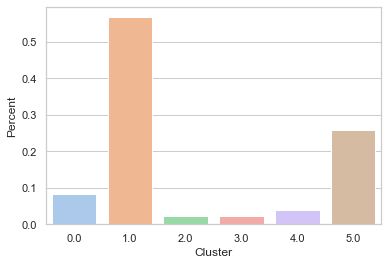

In [604]:
sns.barplot(x=df_count['Cluster'], y=df_count['Percent'], data=df_count, palette = 'pastel')

Explore the clusters top venues

In [598]:
paris_clus0 = paris_merged.loc[paris_merged['Cluster'] == 0]
paris_clus1 = paris_merged.loc[paris_merged['Cluster'] == 1]
paris_clus2 = paris_merged.loc[paris_merged['Cluster'] == 2]
paris_clus3 = paris_merged.loc[paris_merged['Cluster'] == 3]
paris_clus4 = paris_merged.loc[paris_merged['Cluster'] == 4]
paris_clus5 = paris_merged.loc[paris_merged['Cluster'] == 5]

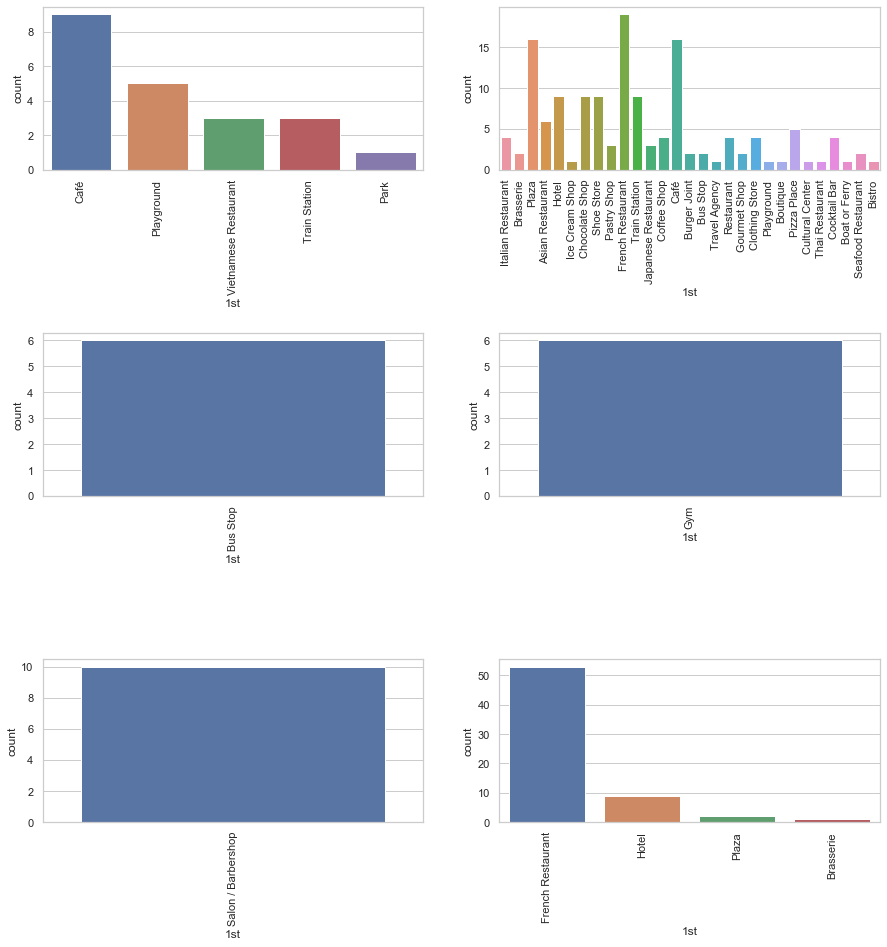

In [603]:
fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.subplots_adjust(hspace = 1)

sns.countplot(x='1st', data=paris_clus0, ax=axs[0,0])
sns.countplot(x='1st', data=paris_clus1, ax=axs[0,1])
sns.countplot(x='1st', data=paris_clus2, ax=axs[1,0])
sns.countplot(x='1st', data=paris_clus3, ax=axs[1,1])
sns.countplot(x='1st', data=paris_clus4, ax=axs[2,0])
sns.countplot(x='1st', data=paris_clus5, ax=axs[2,1])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)